In [1]:
import os
import time
import pkg_resources
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import truebayes.network
import truebayes.geometry
import truebayes.roman
import truebayes.loss
import truebayes.like
import truebayes.plot

In [2]:
# !pip install --upgrade git+https://github.com/vallis/TrueBayes.git

In [4]:
import numpy as np
##geometry.py
def setgeometry(q):
    global qdim, xmin, xmax, xstops, xmid, xwid

    # bins
    qdim = q

    # prior range for x (will be uniform)
    xmin, xmax = 0, 1

    # definition of quantization bins
    xstops = np.linspace(xmin, xmax, qdim + 1)

    # to plot histograms
    xmid = 0.5 * (xstops[:-1] + xstops[1:])
    xwid = xstops[1] - xstops[0]

setgeometry(64)

In [5]:
#utils.py
import torch

def numpy2cuda(array, single=True):
  array = torch.from_numpy(array)
  
  if single:
    array = array.float()
    
  if torch.cuda.is_available():
    array = array.cuda()
    
  return array


def cuda2numpy(tensor):
  return tensor.detach().cpu().numpy()

In [6]:
##network.py
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim


def makenet(dims, softmax=True, single=True):
  """Make a fully connected DNN with layer widths described by `dims`.
  CUDA is always enabled, and double precision is set with `single=False`.
  The output layer applies a softmax transformation,
  disabled by setting `softmax=False`."""

  ndims = len(dims)

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # the weights must be set explicitly as attributes in the class
      # (i.e., we can't collect them in a single list)
      for l in range(ndims - 1):
        layer = nn.Linear(dims[l], dims[l+1])
        
        if not single:
          layer = layer.double()
        
        if torch.cuda.is_available():
          layer = layer.cuda()
        
        setattr(self, f'fc{l}', layer)
                
    def forward(self, x):
      # per Alvin's recipe, apply relu everywhere but last layer
      for l in range(ndims - 2):
        x = F.leaky_relu(getattr(self, f'fc{l}')(x), negative_slope=0.2)

      x = getattr(self, f'fc{ndims - 2}')(x)

      if softmax:
        return F.softmax(x, dim=1)
      else:
        return x
  
  return Net


def makenetbn(dims, softmax=True, single=True):
  """A batch-normalizing version of makenet. Experimental."""

  ndims = len(dims)

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # the weights must be set explicitly as attributes in the class
      # (i.e., we can't collect them in a single list)
      for l in range(ndims - 1):
        layer = nn.Linear(dims[l], dims[l+1])
        bn = nn.BatchNorm1d(num_features=dims[l+1])
        
        if not single:
          layer = layer.double()
          bn = bn.double()
        
        if torch.cuda.is_available():
          layer = layer.cuda()
          bn = bn.cuda()
        
        setattr(self, f'fc{l}', layer)
        setattr(self, f'bn{l}', bn)
                
    def forward(self, x):
      # per Alvin's recipe, apply relu everywhere but last layer
      for l in range(ndims - 2):
        x = getattr(self, f'bn{l}')(F.leaky_relu(getattr(self, f'fc{l}')(x), negative_slope=0.2))

      x = getattr(self, f'fc{ndims - 2}')(x)

      if softmax:
        return F.softmax(x, dim=1)
      else:
        return x
  
  return Net

In [7]:
##loss.py
import math

import numpy as np
import torch

from truebayes.geometry import qdim
from truebayes.utils import numpy2cuda, cuda2numpy

def lossfunction(o, l: 'indicator'):
  """MSE loss for DNN histogram output, labels represented as indicator arrays."""

  return torch.mean(torch.sum(o**2,dim=1) - 2*torch.sum(o*l,dim=1))


def kllossfunction(o, l: 'indicator'):
  """KL loss for DNN histogram output, labels represented as indicator arrays."""

  return -torch.mean(2*torch.sum(torch.log(o)*l, dim=1))


def lossG1(o, l: 'xtrue'):
  """MSE loss for normal-PDF output (represented as a mean/variance pair)."""

  # since int N^2(x;x0,s) dx = 1/(2 sqrt(pi) s)
  # the sqerr loss is 1/(2 sqrt(pi) s) - 2 * e^{-(x_tr - x0)^2/2 s^2} / sqrt(2 pi s^2)
  # multiplying by 2 sqrt(pi)
  
  return torch.mean((1 - 2*math.sqrt(2)*torch.exp(-0.5*(l - o[:,0])**2/o[:,1]**2)) / o[:,1])


def kllossGn(o, l: 'xtrue'):
  """KL loss for Gaussian-mixture output (represented as a vector of concatenated mean/variance/weight triples)."""

  x0 = o[:,0::3]
  std = o[:,1::3]
  weight = torch.softmax(o[:,2::3], dim=1)

  # numerically unstable
  # return -torch.mean(2*torch.log(torch.sum(weight * torch.exp(-0.5*(x0 - l[:,np.newaxis])**2/std**2) / torch.sqrt(2 * math.pi * std**2),dim=1)))
  
  return -torch.mean(torch.logsumexp(torch.log(weight) - 0.5*(x0 - l[:,np.newaxis])**2/std**2 - 0.5*torch.log(2 * math.pi * std**2), dim=1))


def netmeanGn(inputs, net=None, single=True):
  if isinstance(inputs, np.ndarray):
    inputs = numpy2cuda(inputs, single)
    
  pars = cuda2numpy(net(inputs))

  dx  = pars[:,0::3] 
  std = pars[:,1::3]
  pweight = torch.softmax(torch.from_numpy(pars[:,2::3]),dim=1).numpy()

  # see https://en.wikipedia.org/wiki/Mixture_distribution
  xmean = np.sum(pweight * dx, axis=1)
  xerr  = np.sqrt(np.sum(pweight * (dx**2 + std**2), axis=1) - xmean**2)

  return xmean, xerr


def kllossfunction2(o, l: 'indicator'):
  """KL loss over 2-D histogram."""

  q = o.reshape((o.shape[0], qdim, qdim))

  return torch.mean(-torch.sum(torch.log(q)*l, dim=[1,2]))


def kllossGn2(o, l: 'xtrue'):
  """KL loss for Gaussian-mixture output, 2D, precision-matrix parameters."""

  dx  = o[:,0::6] - l[:,0,np.newaxis]
  dy  = o[:,2::6] - l[:,1,np.newaxis]
  
  # precision matrix is positive definite, so has positive diagonal terms
  Fxx = o[:,1::6]**2
  Fyy = o[:,3::6]**2
  
  # precision matrix is positive definite, so has positive 
  Fxy = torch.atan(o[:,4::6]) / (0.5*math.pi) * o[:,1::6] * o[:,3::6]
  
  weight = torch.softmax(o[:,5::6], dim=1)
   
  # omitting the sqrt(4*math*pi) since it's common to all templates
  return -torch.mean(torch.logsumexp(torch.log(weight) - 0.5*(Fxx*dx*dx + Fyy*dy*dy + 2*Fxy*dx*dy) + 0.5*torch.log(Fxx*Fyy - Fxy*Fxy), dim=1))


def netmeanGn2(inputs, net=None, single=True):
  if isinstance(inputs, np.ndarray):
    inputs = numpy2cuda(inputs, single)
    
  pars = cuda2numpy(net(inputs))

  dx, dy = pars[:,0::6], pars[:,2::6] 
  
  Fxx, Fyy = pars[:,1::6]**2, pars[:,3::6]**2
  Fxy = np.arctan(pars[:,4::6]) / (0.5*math.pi) * pars[:,1::6] * pars[:,3::6]

  det = Fxx*Fyy - Fxy*Fxy
  Cxx, Cyy, Cxy = Fyy/det, Fxx/det, -Fxy/det

  pweight = torch.softmax(torch.from_numpy(pars[:,5::6]),dim=1).numpy()

  xmean, ymean = np.sum(pweight * dx, axis=1), np.sum(pweight * dy, axis=1)
  xerr,  yerr  = np.sqrt(np.sum(pweight * (dx**2 + Cxx), axis=1) - xmean**2), np.sqrt(np.sum(pweight * (dy**2 + Cyy), axis=1) - ymean**2) 
  xycov        = np.sum(pweight * (dx*dy + Cxy), axis=1) - xmean*ymean

  return np.vstack((xmean, ymean)).T, np.vstack((xerr, yerr)).T, xycov


def sqerr(o, l: 'xtrue'):
  """Squared error loss for estimator output."""

  return torch.mean((o - l)**2)

In [8]:
import math
import types

import numpy as np
import scipy.special as scs
import matplotlib.pyplot as pp

import torch

from truebayes.geometry import xmid, xwid
from truebayes.loss import netmeanGn2

def makecontour(xytrue, indicator, inputs, net=None, like=None, istart=0, single=True):
  pp.figure(figsize=(12,8))

  if isinstance(like, types.FunctionType):
    like = like(inputs)
    
  for i in range(6):
    netinput = inputs[istart+i:(istart+i+1),:]
    
    with torch.no_grad():
      pars = net(netinput).detach().cpu().numpy().flatten()
      # xm, xe, xc = netmeanGn2(netinput, net=net)
      
    xs, ys = np.meshgrid(xmid, xmid, indexing='ij')    
    
    dx  = pars[0::6] - xs[:,:,np.newaxis]
    Fxx = pars[1::6]**2
  
    dy  = pars[2::6] - ys[:,:,np.newaxis]
    Fyy = pars[3::6]**2
  
    Fxy = np.arctan(pars[4::6]) / (0.5*math.pi) * pars[1::6] * pars[3::6]

    
    weight = torch.softmax(torch.from_numpy(pars[5::6]),dim=0).numpy()

    logmod = scs.logsumexp(np.log(weight) - 0.5*(Fxx*dx*dx + Fyy*dy*dy + 2*Fxy*dx*dy) + 0.5*np.log(Fxx*Fyy - Fxy*Fxy), axis=2)
        
    q = np.exp(logmod)
    q /= np.sum(q)
    
    pmax = np.max(like[istart+i])
    qmax = np.max(q)
    vmax = min(pmax, qmax)
    
    pp.subplot(3,2,i+1)

    pp.plot([xytrue[istart+i,0]], [xytrue[istart+i,1]], 'ro')

    # note these are set-value posterior levels, not true set-mass-containing contours
    pp.contour(xs, ys, like[istart+i], colors='k', alpha=0.3, levels=[0.01*vmax,0.14*vmax,0.61*vmax])
    pp.contour(xs, ys, q,              colors='r', alpha=0.3, levels=[0.01*vmax,0.14*vmax,0.61*vmax])


def plotgauss(xtrue, indicator, inputs, net=None, like=None, varx=None, twodim=False, istart=0, single=True):  
  pp.figure(figsize=(12,8))

  if isinstance(like, types.FunctionType):
    like = like(inputs)

  for i in range(6):
    pp.subplot(3,2,i+1)

    # make and plot Gaussian mixture
    
    netinput = inputs[istart+i:(istart+i+1),:]
    with torch.no_grad():
      pars = net(netinput).detach().cpu().numpy().flatten()
    
    if twodim:
      Fxx, Fyy = pars[1::6]**2, pars[3::6]**2
      Fxy = np.arctan(pars[4::6]) / (0.5*math.pi) * pars[1::6] * pars[3::6]
      weight = torch.softmax(torch.from_numpy(pars[5::6]),dim=0).numpy()

      dx  = (pars[2::6] if varx == 'nu' else pars[0::6]) - xmid[:,np.newaxis]
      Cxx = Fxx / (Fxx*Fyy - Fxy*Fxy) if varx == 'nu' else Fyy / (Fxx*Fyy - Fxy*Fxy) 

      pdf = np.sum(weight * np.exp(-0.5*dx**2/Cxx) / np.sqrt(2*math.pi*Cxx) * xwid, axis=1)

      # logmod = scs.logsumexp(np.log(weight) - 0.5*(Fxx*dx*dx + Fyy*dy*dy + 2*Fxy*dx*dy) + 0.5*np.log(Fxx*Fyy - Fxy*Fxy), axis=2)
    else:
      if len(pars) == 2:
        pdf = np.exp(-0.5*(xmid - pars[0])**2/pars[1]**2) / math.sqrt(2*math.pi*pars[1]**2) * xwid
      else:
        wg = torch.softmax(torch.from_numpy(pars[2::3]), dim=0).numpy()
        pdf = np.sum(wg * np.exp(-0.5*(xmid[:,np.newaxis] - pars[0::3])**2/pars[1::3]**2) / np.sqrt(2*math.pi*pars[1::3]**2) * xwid, axis=1)
    
    pp.plot(xmid, pdf, color='C0')
    
    # plot likelihood
    pp.plot(xmid, like[istart+i], color='C1')

    # show true x
    if xtrue.ndim == 2:
      ix = ['theta_N', 'phi'].index(varx)
      pp.axvline(xtrue[istart+i, ix], color='C2', ls=':')
    else:
      pp.axvline(xtrue[istart+i], color='C2', ls=':')

In [3]:
from GWFunctions_v3 import h_func_f2
#from GWFunctions_v2 import h_func_f2_no_noise
#+- 30 degrees from equator
cos_theta_min = 0.5
cos_theta_max = -0.5
phi_min = np.pi
phi_max = 3*np.pi/2


In [4]:
h_func_f2((0.5, np.pi/2), noise_ind=1)

array([[-1.36461093e+03+4.31694848e+02j,  1.35865919e+03-4.60337434e+02j,
        -1.36205110e+03+4.64607898e+02j,  1.37325783e+03-4.44740087e+02j,
        -1.39053682e+03+3.99253105e+02j,  1.41394927e+03-3.26844164e+02j,
        -1.43817008e+03+2.28106005e+02j,  1.45645687e+03-9.91727027e+01j,
        -1.46406454e+03-5.73731239e+01j,  1.44928121e+03+2.41717476e+02j,
        -1.40320595e+03-4.50350348e+02j,  1.31478626e+03+6.76436375e+02j,
        -1.17411256e+03-9.07385395e+02j,  9.69899632e+02+1.12947439e+03j,
        -6.99878440e+02-1.31934165e+03j,  3.64977471e+02+1.45357761e+03j,
         2.28018817e+01-1.50405363e+03j, -4.41218849e+02+1.44356096e+03j,
         8.53133749e+02-1.25189046e+03j, -1.20946232e+03+9.21863741e+02j,
         1.45398562e+03-4.64240122e+02j, -1.53027405e+03-8.22117427e+01j,
         1.39460699e+03+6.50049590e+02j, -1.03060739e+03-1.15109733e+03j,
         4.66379768e+02+1.47947780e+03j,  2.17952826e+02-1.54131128e+03j,
        -8.92788200e+02+1.28345393e+03

In [10]:
def syntrain(size,  region=[[cos_theta_min, cos_theta_max], [phi_min, phi_max]], varx='theta_N', 
             varall=True, seed=None, single=True, noise=1):
    """Makes a training set using the ROMAN NN. It returns labels (for `varx`,
        or for all if `varall=True`), indicator vectors, and ROM coefficients
        (with `snr` and `noise`). Note that the coefficients are kept on the GPU.
        Parameters are sampled randomly within `region`."""
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu:0'
    
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    with torch.no_grad():
        xs = torch.zeros((size,2), dtype=torch.float, device=device)

        for i, r in enumerate(region):
            xs[:,i] = r[0] + (r[1] - r[0]) * torch.rand((size,), dtype=torch.float, device=device)
        
        xs_1 = xs.detach().cpu().double().numpy()
        
        #generating signals
        signal = np.apply_along_axis(h_func_f2, 1, xs_1, noise)[:,:,0]
            
        signal_r, signal_i = numpy2cuda(signal.real), numpy2cuda(signal.imag)
        
        #setting up real and imag alphas
        alphas = torch.zeros((size, 200*2), dtype=torch.float if single else torch.double, device=device)
        
        alphas[:,0::2] = signal_r 
        alphas[:,1::2] = signal_i 

    xr = xs.detach().cpu().double().numpy()

    del xs, signal_r, signal_i

      # normalize (for provided regions)
    for i, r in enumerate(region):
        xr[:,i] = (xr[:,i] - r[0]) / (r[1] - r[0])

    if isinstance(varx, list):
        ix = ['theta_N','phi'].index(varx[0])
        jx = ['theta_N','phi'].index(varx[1])    

        i = np.digitize(xr[:,ix], xstops, False) - 1
        i[i == -1] = 0; i[i == qdim] = qdim - 1
        px = np.zeros((size, qdim), 'd'); px[range(size), i] = 1

        j = np.digitize(xr[:,jx], xstops, False) - 1
        j[j == -1] = 0; j[j == qdim] = qdim - 1
        py = np.zeros((size, qdim), 'd'); py[range(size), j] = 1

        if varall:
            return xr, np.einsum('ij,ik->ijk', px, py), alphas
        else:
            return xr[:,[ix,jx]], np.einsum('ij,ik->ijk', px, py), alphas    
    else:
        ix = ['theta_N','phi'].index(varx)

        i = np.digitize(xr[:,ix], xstops, False) - 1
        i[i == -1] = 0; i[i == qdim] = qdim - 1
        px = np.zeros((size, qdim), 'd'); px[range(size), i] = 1

        if varall:
            return xr, px, alphas
        else:
            return xr[:,ix], px, alphas

In [ ]:
%%time
syntrain(10000)

In [11]:
def syntrainer(net, syntrain, lossfunction=None, iterations=300, 
               batchsize=None, initstep=1e-3, finalv=1e-5, clipgradient=None, validation=None,
               seed=None, single=True):
  """Trains network NN against training sets obtained from `syntrain`,
  iterating at most `iterations`; stops if the derivative of loss
  (averaged over 20 epochs) becomes less than `finalv`."""

  if seed is not None:
    np.random.seed(seed)
    torch.manual_seed(seed)

  indicatorloss = 'l' in lossfunction.__annotations__ and lossfunction.__annotations__['l'] == 'indicator'  
  
  if validation is not None:
    raise NotImplementedError
    
    vlabels = numpy2cuda(validation[1] if indicatorloss else validation[0], single)
    vinputs = numpy2cuda(validation[2], single)
  
  optimizer = optim.Adam(net.parameters(), lr=initstep)

  training_loss, validation_loss = [], []
  
  for epoch in range(iterations):
    t0 = time.time()

    xtrue, indicator, inputs = syntrain()
    labels = numpy2cuda(indicator if indicatorloss else xtrue, single)

    if batchsize is None:
      batchsize = inputs.shape[0]
    batches = inputs.shape[0] // batchsize

    averaged_loss = 0.0    
    
    for i in range(batches):
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs[i*batchsize:(i+1)*batchsize])
      loss = lossfunction(outputs, labels[i*batchsize:(i+1)*batchsize])
      loss.backward()
      
      if clipgradient is not None:
        torch.nn.utils.clip_grad_norm_(net.parameters(), clipgradient)
      
      optimizer.step()

      # print statistics
      averaged_loss += loss.item()

    training_loss.append(averaged_loss/batches)

    if validation is not None:
      loss = lossfunction(net(vinputs), vlabels)
      validation_loss.append(loss.detach().cpu().item())

    if epoch == 1:
      print("One epoch = {:.1f} seconds.".format(time.time() - t0))

    if epoch % 50 == 0:
      print(epoch,training_loss[-1],validation_loss[-1] if validation is not None else '')

    try:
      if len(training_loss) > iterations/10:
        training_rate = np.polyfit(range(20), training_loss[-20:], deg=1)[0]
        if training_rate < 0 and training_rate > -finalv:
          print(f"Terminating at epoch {epoch} because training loss stopped improving sufficiently: rate = {training_rate}")
          break

      if len(validation_loss) > iterations/10:
        validation_rate = np.polyfit(range(20), validation_loss[-20:], deg=1)[0]        
        if validation_rate > 0:
          print(f"Terminating at epoch {epoch} because validation loss started worsening: rate = {validation_rate}")
          break
    except:
      pass
          
  print("Final",training_loss[-1],validation_loss[-1] if validation is not None else '')
      
  if hasattr(net,'steps'):
    net.steps += iterations
  else:
    net.steps = iterations

In [12]:
dimensions = [200*2] + [1024]*8 + [1*6]
percival_network = makenet(dimensions, softmax=False)

network_to_use = percival_network()

##Training data to pass through Percival network
training_data = lambda: syntrain(size=100000, varx='theta_N')

##Train Percival network on above data

In [24]:
%%time
##training the network
syntrainer(network_to_use, training_data, lossfunction=kllossGn2, iterations=100,
           initstep=1e-4, finalv=1e-8)

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 4.00 GiB total capacity; 2.87 GiB already allocated; 0 bytes free; 2.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [13]:
PATH = "C:\\Users\\Luke\\year-4-project-lisa\\Luke"

In [26]:
torch.save(network_to_use.state_dict(), PATH + '\\Trained-Networks\\theta-phi_l200-1024x8_2d.pt') 
#insert name for net e.g #percival/Mc-nu_l1024x8_g1_SNR8-16_2d.pt

In [14]:
network_to_use.load_state_dict(torch.load(PATH + '\\Trained-Networks\\theta-phi_l200-1024x8_2d.pt'))

<All keys matched successfully>

In [18]:
mutest = syntrain(5000)

In [19]:
theta_N = mutest[0][:,0]
phi = mutest[0][:,1]

In [20]:
idx = np.argsort(theta_N)

In [21]:
from truebayes.utils import numpy2cuda, cuda2numpy


def synlike(a, syntrain, iterations=1000000):
  with torch.no_grad():
    # note aimag defined with plus here, exp below modified consistently
    # [areal] = [aimag] = nbasis x nsignals 
    areal, aimag = torch.t(a[:,0::2]), torch.t(a[:,1::2])

    # [anorm] = nsignals
    anorm = torch.sum(areal*areal + aimag*aimag, dim=0)
    
    cnt, norm, like = 0, 0, 0
    adapt = None
    while cnt < iterations:
      # [pxt] = nbatch x qdim
      _, pxt, alpha = syntrain()
      cnt = cnt + alpha.shape[0]

      # cpxt = torch.from_numpy(pxt).cuda()
      # handle 2D indicator array (assume square qdim)
      cpxt = numpy2cuda(pxt if pxt.ndim == 2 else pxt.reshape((pxt.shape[0], pxt.shape[1]*pxt.shape[1])),
                        alpha.dtype == torch.float32)
      
      # [alphareal] = [alphaimag] = nbatch x nbasis
      alphareal, alphaimag = alpha[:,0::2], alpha[:,1::2]

      # [norm] = qdim
      norm += torch.sum(cpxt, dim=0)
      
      # [alphanorm] = nbatch
      alphanorm = torch.sum(alphareal*alphareal + alphaimag*alphaimag, dim=1)

      # automatic normalization of exponentials based on the first batch
      loglike = (alphareal @ areal + alphaimag @ aimag - 0.5*alphanorm.unsqueeze(1) - 0.5*anorm)*1/100000
      if adapt is None:
        adapt = torch.max(loglike, dim=0)[0]
      loglike -= adapt

      # [like] = qdim x nsignals = (qdim x nbatch) @ [(nbatch x nbasis) @ (nbasis x nsignals) + (nbatch x 1) + nsignals]
      # remember broadcasting tries to match the last dimension [so A @ b = sum(A * b,axis=1)]
      like += torch.t(cpxt) @ torch.exp(loglike)

    # (qdim x nsignals) * (qdim x 1)
    like = like / norm.unsqueeze(1)  
    
    # [ret] = nsignals x qdim = (nsignals x qdim) * qdim
    ret = torch.t(like / torch.sum(like, dim=0))
    
    nret = ret.detach().cpu().numpy()
    
  return nret if pxt.ndim == 2 else nret.reshape((nret.shape[0], pxt.shape[1], pxt.shape[1]))

In [22]:
likeset_theta_N = lambda: syntrain(size=10000, varx='theta_N', region=[[cos_theta_min, cos_theta_max], [phi_min, phi_max]], noise=0)
likeset_phi = lambda: syntrain(size=10000, varx='phi', region=[[cos_theta_min, cos_theta_max], [phi_min, phi_max]], noise=0)
likeset_2 = lambda: syntrain(size=10000, varx=['theta_N','phi'], region=[[cos_theta_min, cos_theta_max], [phi_min, phi_max]], noise=0)

In [23]:
%%time
sl_theta_N = synlike(mutest[2][:24,:], likeset_theta_N, iterations=1000000)

Wall time: 6min 35s


In [24]:
%%time
sl_phi = synlike(mutest[2][:24,:], likeset_phi, iterations=1000000)

Wall time: 6min 40s


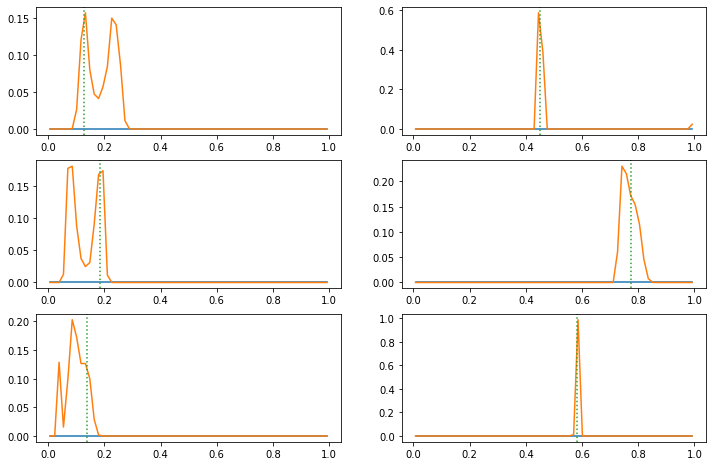

In [25]:
plotgauss(*mutest, net=network_to_use, varx='theta_N', like=sl_theta_N, twodim=True, istart=6)